# Generate MetaData for Species Audio Files

This program is designed to create metadata for audio files in a specified directory. It accomplishes this in several steps:

CalcAudioDuration(length): This function calculates the audio duration in seconds, given the length of the audio in milliseconds. It converts milliseconds to seconds and returns the duration.

ComputeAudioDuration(filename): This function retrieves the duration of audio files. It first checks if the file exists and has a supported format (e.g., '.wav' or '.mp3'). If supported, it loads the audio file, calculates its length, and uses CalcAudioDuration to get the duration in seconds. Any errors during this process are caught and printed.

ExtractClassAndFile(path): This function extracts class names and filenames from subdirectories within a specified directory. It lists the subdirectories, iterates through them, and collects the class and filename information.

GetAudioDurations(path, classes, filenames): This function calculates the durations of audio files in the specified directory. It uses the ComputeAudioDuration function to process each audio file, collecting the durations into a list.

CreateMetaData(path): This function generates metadata for the audio files. It combines the class, filename, and duration information into a Pandas DataFrame and returns it.

WriteMetadata(path): This function writes the metadata DataFrame to a CSV file named 'species_metadata.csv' in the specified directory.

The script sets the 'path' variable to the directory containing the audio files and then calls 'WriteMetadata' to generate and save the metadata as a CSV file. This code ensures that the audio file durations are calculated accurately and included in the metadata for further analysis or use.

In [1]:
# Import the libraries
import os
from pydub import AudioSegment
import pandas as pd

In [2]:
# Import the libraries
import os
from pydub import AudioSegment
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
# Functions to compute and generate csv file

def CalcAudioDuration(length):
    """
    Function to compute the duration. You could add more features like hours and minutes here, 
    but for now it would just be seconds.
    """
    seconds = length / 1000  # Convert milliseconds to seconds
    return seconds

def ComputeAudioDuration(filename):
    """
    This function will retrieve the duration from any file passed to it
    """
    try:
        ext = os.path.splitext(filename)[-1].lower()
        if ext not in ['.wav', '.mp3']:
            raise ValueError("Unsupported audio format")

        audio = AudioSegment.from_file(filename)
        length = len(audio)
        seconds = CalcAudioDuration(length)
        return seconds
    except Exception as e:
        print(f"Error loading {filename}: {e}")
        return None

def ExtractClassAndFile(path):
    classes = []
    filenames = []
    # sizes are in bytes
    filesizes = []
    classsizes = []
    for folder in os.listdir(path):
        folderpath = os.path.join(path, folder)
        if os.path.isdir(folderpath):
            for file in os.listdir(folderpath):
                classsizes.append(os.path.getsize(folderpath))
                filesizes.append(os.path.getsize((folderpath+'//'+file)))
                if file.endswith(('.wav', '.mp3')):
                    classes.append(folder)
                    filenames.append(file)
    return classes, filenames, filesizes, classsizes



def GetAudioDurations(path, classes, filenames):
    seconds = []
    for cls, filename in zip(classes, filenames):
        filepath = os.path.join(path, cls, filename)
        second = ComputeAudioDuration(filepath)
        seconds.append(second)
    return seconds

def ComputeClassDetails(meta_data_df):
    
    """This function that will calculate the total number of files in the folder/class
        and also their total duration in HH:MM:SS format"""
    
    result_df = meta_data_df.groupby('Class').agg(
        {'Filename': 'count', 'Seconds': 'sum'}
    ).reset_index()
    result_df.rename(columns={'Filename': 'No. of Samples'}, inplace=True)
    result_df['Seconds'] = result_df['Seconds'].round().astype(int)
    result_df['Total Duration'] = pd.to_timedelta(result_df['Seconds'], unit='s').apply(lambda x: str(x).split()[-1])
    result_df = result_df.drop(columns=['Seconds'])
    return result_df

# Function to create metadata table
def CreateMetaData(path):
    classes, filenames, filesizes, classsizes = ExtractClassAndFile(path)
    seconds = GetAudioDurations(path, classes, filenames)
    feature_colname = ['filename', 'seconds', 'class']
    df = pd.DataFrame({'Class': classes, 'Filename': filenames, 'Filesize': filesizes, 'Seconds': seconds, 'Filesize_by_class': classsizes})
    df['Seconds'] = df['Seconds'].fillna(0)
    df1 = df.groupby('Class').agg({'Filename': 'count', 'Seconds': 'sum'}).reset_index()
    df1.rename(columns={'Filename': 'Total_samples_by_class'}, inplace=True)
    df1['Seconds'] = df1['Seconds'].round().astype(int)
    df1['Total_duration_by_class'] = pd.to_timedelta(df1['Seconds'], unit='s').apply(lambda x: str(x).split()[-1])
    df1 = df1.drop(columns=['Seconds'])
    df_join = pd.merge(df, df1, on='Class', how='inner')
    return df_join

# Function to write csv
def WriteMetadata(path):
    df = CreateMetaData(path)
    df.to_csv(os.path.join(path, 'species_metadata.csv'), index=False)

# Assign the path as required
#path = "Data2/"
path = "/Users/rahulprem/Uni/SIT782/Test2/"

# Create metadata df
df = CreateMetaData(path)

Finally, the script sets the 'path' variable to "./Data2/" and calls the 'WriteMetadata' function with this path, which generates metadata for audio files in the "./Data2/" directory and saves it in a CSV file named 'species_metadata.csv'.

In [4]:
print("The metadata of given directory is: \n")
#pd.read_csv('Data2/species_metadata.csv').head()
pd.read_csv('/Users/rahulprem/Uni/SIT782/Test2/species_metadata.csv').head()


The metadata of given directory is: 



,Filename,Seconds,Class
0,region_34.000-36.000.mp3,2.029,Acanthiza chrysorrhoa
1,region_11.750-13.750.mp3,2.052,Acanthiza chrysorrhoa
2,region_15.200-16.050.mp3,0.877,Acanthiza chrysorrhoa
3,region_29.050-31.050.mp3,2.052,Acanthiza chrysorrhoa
4,region_10.150-12.150.mp3,2.029,Acanthiza chrysorrhoa


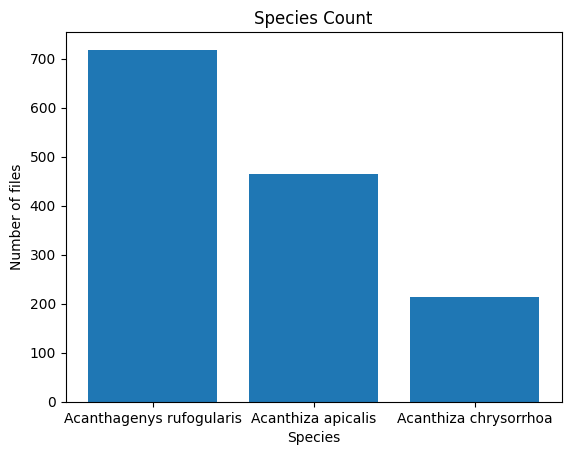

In [5]:
# Bar plot for number of classes

plt.bar(pd.unique(df.sort_values(by=['Class'])['Class']), pd.unique(df.sort_values(by=['Class'])['Total_samples_by_class']))
plt.xlabel("Species")
plt.ylabel("Number of files")
plt.title("Species Count")
plt.show()

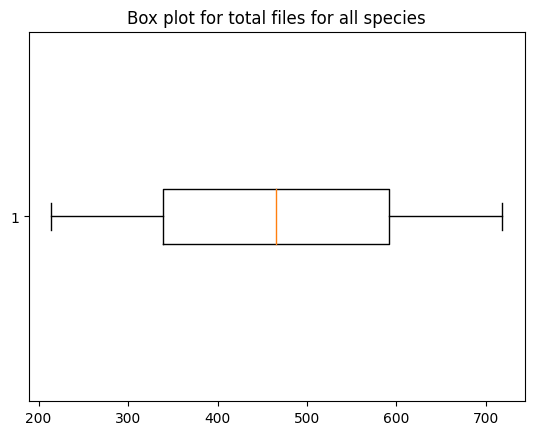


Outlier-Classes - The class which are extreme in number of samples are: 

   Acanthiza chrysorrhoa
      Acanthiza apicalis
Acanthagenys rufogularis


In [6]:
# Box plot for total files for all species

df_filecount = df.groupby(by="Class").count().reset_index()[['Class', 'Filename']].rename(columns = {'Filename' : 'Count'}).sort_values('Count')

# Creating plot
plt.boxplot(df_filecount['Count'], vert= False)
plt.title("Box plot for total files for all species")

# show plot
plt.show()

# Code to spot outliers

q1 = np.percentile(df_filecount['Count'], 25)
q3 = np.percentile(df_filecount['Count'], 75)
iqr = q3 - q1
threshold = 1.5 * iqr
outliers = np.where((df_filecount['Count']< q1 - threshold) | (df_filecount['Count']< q3 + threshold))

print("\nOutlier-Classes - The class which are extreme in number of samples are: \n")
print(df_filecount[df_filecount.index.isin(list(outliers[0]))]['Class'].to_string(index=False))


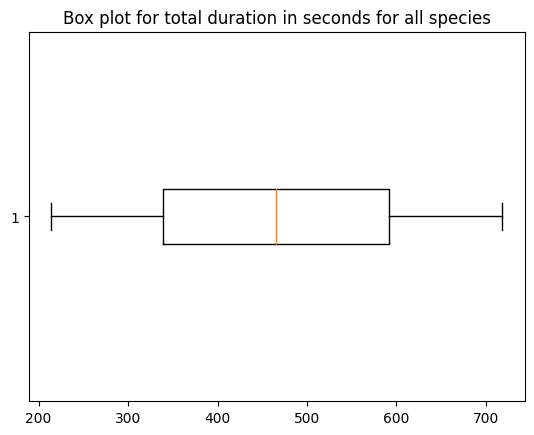


Outlier-Classes - The class which are extreme in number of samples are: 

   Acanthiza chrysorrhoa
      Acanthiza apicalis
Acanthagenys rufogularis


In [8]:
# Box plot for total seconds for all species

df_total_seconds = df.groupby(by="Class").count().reset_index()[['Class', 'Seconds']].rename(columns = {'Seconds' : 'Count'}).sort_values('Count')

# Creating plot
plt.boxplot((df_total_seconds['Count']), vert= False)
plt.title("Box plot for total duration in seconds for all species")

# show plot
plt.show()

# Code to spot outliers

q1 = np.percentile(df_total_seconds['Count'], 25)
q3 = np.percentile(df_total_seconds['Count'], 75)
iqr = q3 - q1
threshold = 1.5 * iqr
outliers = np.where((df_total_seconds['Count']< q1 - threshold) | (df_total_seconds['Count']< q3 + threshold))

print("\nOutlier-Classes - The class which are extreme in number of samples are: \n")
print(df_total_seconds[df_total_seconds.index.isin(list(outliers[0]))]['Class'].to_string(index=False))

In [9]:
# Summary stats about number of files per species

# Minimum
min_count = min(df_filecount['Count'])
min_count_species = df_filecount[df_filecount['Count']==min_count]['Class'].to_string(index=False)
print(f"The minimum file count is: {min_count} for the species: {min_count_species}")

# Maximum
max_count = max(df_filecount['Count'])
max_count_species = df_filecount[df_filecount['Count']==max_count]['Class'].to_string(index=False)
print(f"\nThe maximum file count is: {max_count} for the species: {max_count_species}")

# Mean
print(f"\nThe mean value of number of files is :{(df_filecount['Count']).mean()}")

The minimum file count is: 214 for the species: Acanthiza chrysorrhoa

The maximum file count is: 718 for the species: Acanthagenys rufogularis

The mean value of number of files is :465.6666666666667


In [10]:
# Summary stats about duration of files per species

df_duration_summary = (df.groupby('Class').agg({'Seconds': ['mean', 'min', 'max']}))\
                      .droplevel(0, axis = 1).reset_index().rename(columns= {'mean':'Seconds_by_class_mean', \
                      'min':'Seconds_by_class_min', 'max':'Seconds_by_class_max'})

df_final = pd.merge(df, df_duration_summary, on ='Class', how = 'inner')
df_final.head()

,Class,Filename,Filesize,Seconds,Filesize_by_class,Total_samples_by_class,Total_duration_by_class,Seconds_by_class_mean,Seconds_by_class_min,Seconds_by_class_max
0,Acanthiza chrysorrhoa,region_34.000-36.000.mp3,33069,2.029,6912,214,00:06:42,1.877692,0.51,2.052
1,Acanthiza chrysorrhoa,region_11.750-13.750.mp3,33405,2.052,6912,214,00:06:42,1.877692,0.51,2.052
2,Acanthiza chrysorrhoa,region_15.200-16.050.mp3,14637,0.877,6912,214,00:06:42,1.877692,0.51,2.052
3,Acanthiza chrysorrhoa,region_29.050-31.050.mp3,33405,2.052,6912,214,00:06:42,1.877692,0.51,2.052
4,Acanthiza chrysorrhoa,region_10.150-12.150.mp3,33069,2.029,6912,214,00:06:42,1.877692,0.51,2.052


In [11]:
# Write to csv file

df_final.to_csv(os.path.join(path, 'species_metadata.csv'), index=False)

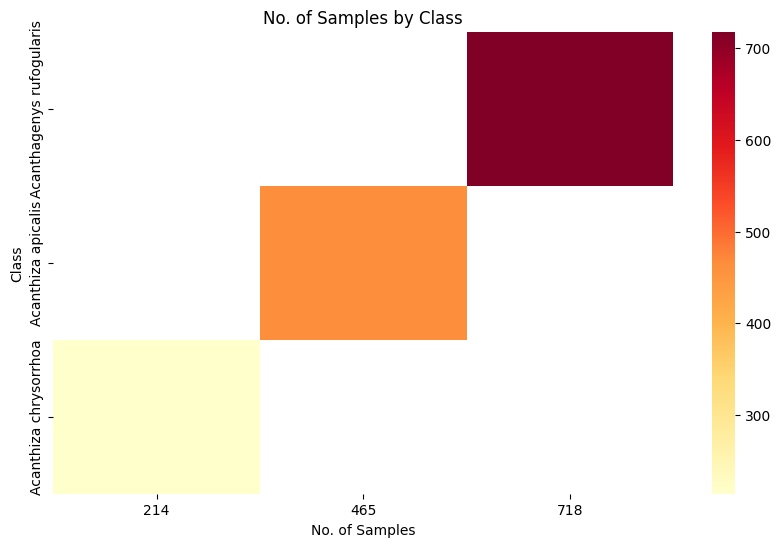

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

result_df = ComputeClassDetails(df_final)
# Pivot the dataframe to create a heatmap for No. of Samples
heatmap_samples = result_df.pivot(index='Class', columns='No. of Samples', values='No. of Samples')

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_samples, annot=False, cmap='YlOrRd')
plt.title('No. of Samples by Class')
plt.show()